In [62]:
###IMPORTING THE LIBRARIES
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import col,sum,avg,round,monotonically_increasing_id,lit,filter
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
#CREATING THE SESSION
sesion=SparkSession.builder.appName("sesion").getOrCreate()

In [45]:
df=sesion.read.csv("churn.csv",header=True,sep=",")
df.show(5)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|        0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|        0|            2|        0|             0|       93826.63|

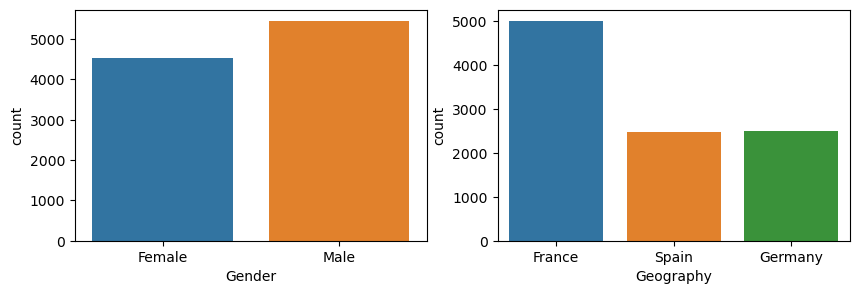

In [46]:
#Analyzing the distributions of the categorical features

import matplotlib.pyplot as plt
import seaborn as sns

df_pandas = df.select("Gender", "Geography").toPandas()

# Set up the figure size
f, axes = plt.subplots(1, 2, figsize=(10, 3))

# Create a count plot for the "Gender" column
sns.countplot(data=df_pandas, x="Gender", ax=axes[0])

# Create a count plot for the "Geography" column
sns.countplot(data=df_pandas, x="Geography", ax=axes[1])

# Display the plots
plt.show()

In [52]:
#Dropping the columns that do not add value
columns_to_drop = df.columns[0:3]
df = df.drop(*columns_to_drop)
df.show(5)

+---+------+---------+-------------+---------+--------------+---------------+------+
|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---+------+---------+-------------+---------+--------------+---------------+------+
| 42|     2|        0|            1|        1|             1|      101348.88|     1|
| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
| 39|     1|        0|            2|        0|             0|       93826.63|     0|
| 43|     2|125510.82|            1|        1|             1|        79084.1|     0|
+---+------+---------+-------------+---------+--------------+---------------+------+
only showing top 5 rows



In [53]:
#FINDING THE SHAPE OF THE DATA
rows=df.count()
columns=len(df.columns)
print(f"rows: {rows} | columns: {columns}")

rows: 10000 | columns: 8


In [54]:
#ANALYZING THE DATA
df.printSchema()

root
 |-- Age: string (nullable = true)
 |-- Tenure: string (nullable = true)
 |-- Balance: string (nullable = true)
 |-- NumOfProducts: string (nullable = true)
 |-- HasCrCard: string (nullable = true)
 |-- IsActiveMember: string (nullable = true)
 |-- EstimatedSalary: string (nullable = true)
 |-- Exited: string (nullable = true)



In [55]:
##Converting all the columns to float
from pyspark.sql.functions import col
df = df.select([col(c).cast("float").alias(c) for c in df.columns])
df.show(5)

+----+------+---------+-------------+---------+--------------+---------------+------+
| Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+----+------+---------+-------------+---------+--------------+---------------+------+
|42.0|   2.0|      0.0|          1.0|      1.0|           1.0|      101348.88|   1.0|
|41.0|   1.0| 83807.86|          1.0|      0.0|           1.0|      112542.58|   0.0|
|42.0|   8.0| 159660.8|          3.0|      1.0|           0.0|      113931.57|   1.0|
|39.0|   1.0|      0.0|          2.0|      0.0|           0.0|       93826.63|   0.0|
|43.0|   2.0|125510.82|          1.0|      1.0|           1.0|        79084.1|   0.0|
+----+------+---------+-------------+---------+--------------+---------------+------+
only showing top 5 rows



In [56]:
##FINDING THE % OF NULL VALUES
from pyspark.sql import functions as F

# Calcular el número total de filas
total_rows = df.count()

# Crear una lista de expresiones para calcular el porcentaje de valores nulos
null_percentage_expr = [
    round((F.sum(F.col(c).isNull().cast("int")) / total_rows * 100), 1).alias(c) 
    for c in df.columns
]

# Aplicar las expresiones y obtener los porcentajes de valores nulos
null_percentages_df = df.agg(*null_percentage_expr)

# Convertir el DataFrame en formato de dos columnas (Columna, Porcentaje de Nulos)
null_percentages = null_percentages_df.select(F.explode(F.array([
    F.struct(F.lit(c).alias("Column"), F.col(c).alias("Null_Percentage")) 
    for c in df.columns
]))).select("col.*")

# Ordenar el resultado en orden descendente por el porcentaje de valores nulos
null_percentages.orderBy(F.col("Null_Percentage").desc()).show()

+---------------+---------------+
|         Column|Null_Percentage|
+---------------+---------------+
|            Age|            0.0|
|         Tenure|            0.0|
|        Balance|            0.0|
|  NumOfProducts|            0.0|
|      HasCrCard|            0.0|
| IsActiveMember|            0.0|
|EstimatedSalary|            0.0|
|         Exited|            0.0|
+---------------+---------------+



## CREATING THE MODEL

In [63]:
# Creating a feature vector
feature_columns = [col for col in df.columns if col != 'Exited']

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Creating a  pipeline
pipeline = Pipeline(stages=[assembler])

In [66]:
# Applying the pipeline
data_prepared = pipeline.fit(df).transform(df)

#Splitting the data in train and test
train_df, test_df = data_prepared.randomSplit([0.8, 0.2], seed=42)

In [72]:
# Create the RandomForest model
rf = RandomForestClassifier(labelCol="Exited", featuresCol="features")

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="Exited", predictionCol="prediction", metricName="accuracy")

# Create and train the model
rf_model = rf.fit(train_df)

# Make predictions
predictions = rf_model.transform(test_df)

# Evaluate the model
accuracy = evaluator.evaluate(predictions)

# Compute other metrics like F1-score, precision, and recall
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="Exited", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)

precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="Exited", predictionCol="prediction", metricName="precisionByLabel")
precision = precision_evaluator.evaluate(predictions)

recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="Exited", predictionCol="prediction", metricName="recallByLabel")
recall = recall_evaluator.evaluate(predictions)

# Convert metrics to percentage and round to 1 decimal place
accuracy = evaluator.evaluate(predictions) * 100
f1_score = f1_evaluator.evaluate(predictions) * 100
precision = precision_evaluator.evaluate(predictions) * 100
recall = recall_evaluator.evaluate(predictions) * 100

print(f"Accuracy: {accuracy:.1f}%")
print(f"F1 Score: {f1_score:.1f}%")
print(f"Precision: {precision:.1f}%")
print(f"Recall: {recall:.1f}%")

Accuracy: 85.4%
F1 Score: 83.3%
Precision: 85.8%
Recall: 97.6%


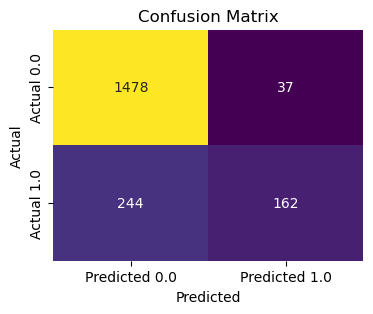

In [71]:
# Compute confusion matrix
confusion_matrix_df = predictions.groupBy("Exited", "prediction").count().toPandas()

# Create a confusion matrix in the format needed
confusion_matrix = confusion_matrix_df.pivot_table(index='Exited', columns='prediction', values='count', fill_value=0)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='viridis', cbar=False,
            xticklabels=[f'Predicted {i}' for i in confusion_matrix.columns],
            yticklabels=[f'Actual {i}' for i in confusion_matrix.index])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()